https://adriangb.com/scikeras/stable/notebooks/Basic_Usage.html#7.-Usage-with-sklearn-GridSearchCV

In [ ]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [1]:
!pip install pandas_ta
!pip install yfinance
!pip install scikeras
!pip install keras-tuner --upgrade

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive/Praca_mgr/nowe/23_30_ret_LSTM')

Mounted at /content/gdrive


2023-05-21 05:44:43.996670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 05:44:44.904473: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-21 05:44:44.904509: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-21 05:44:47.717006: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

[*********************100%***********************]  1 of 1 completed
2014
1612
201
201


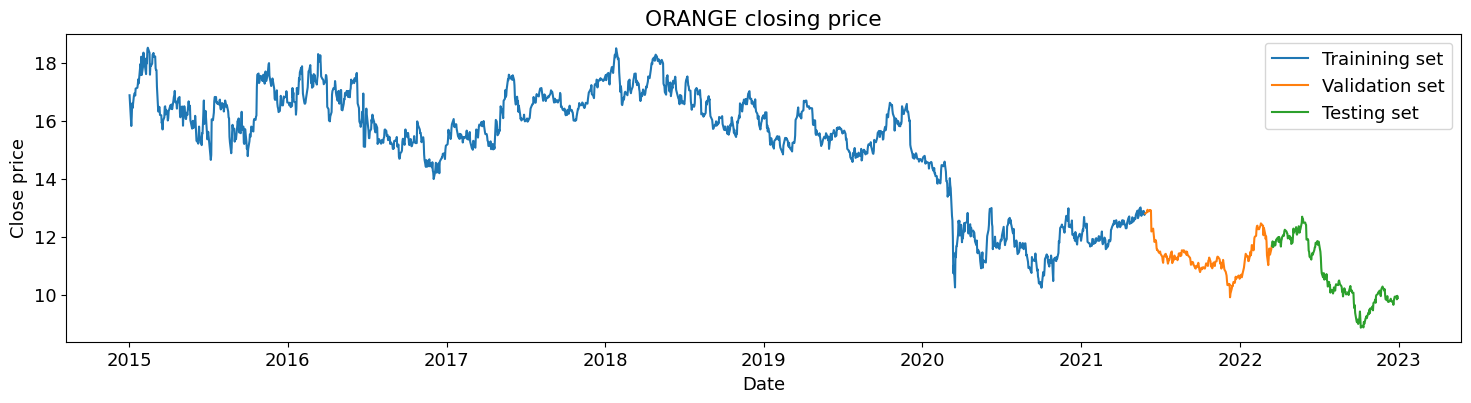

[*********************100%***********************]  1 of 1 completed
2014
1612
201
201


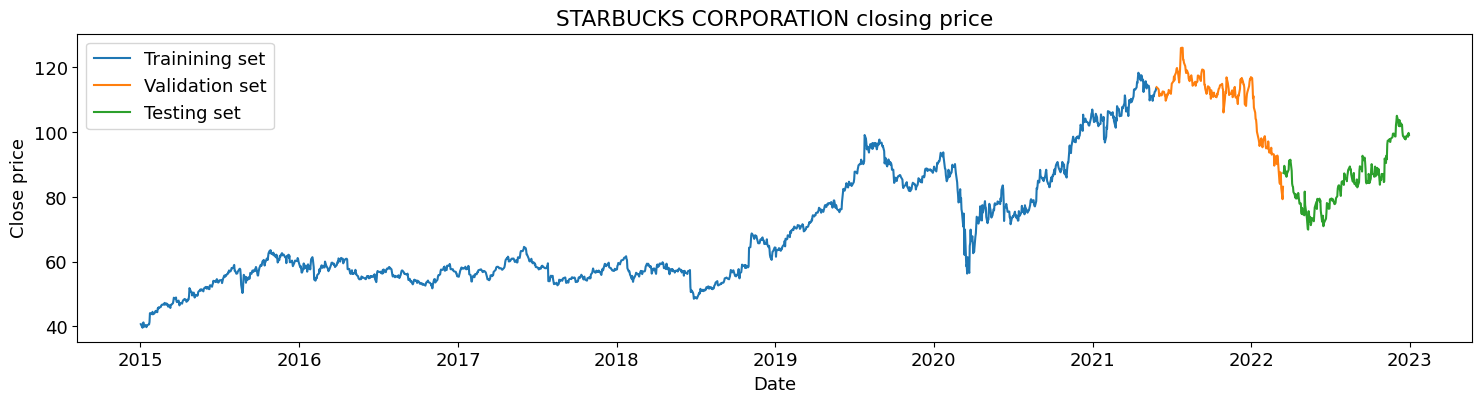

[*********************100%***********************]  1 of 1 completed
2060
1648
206
206


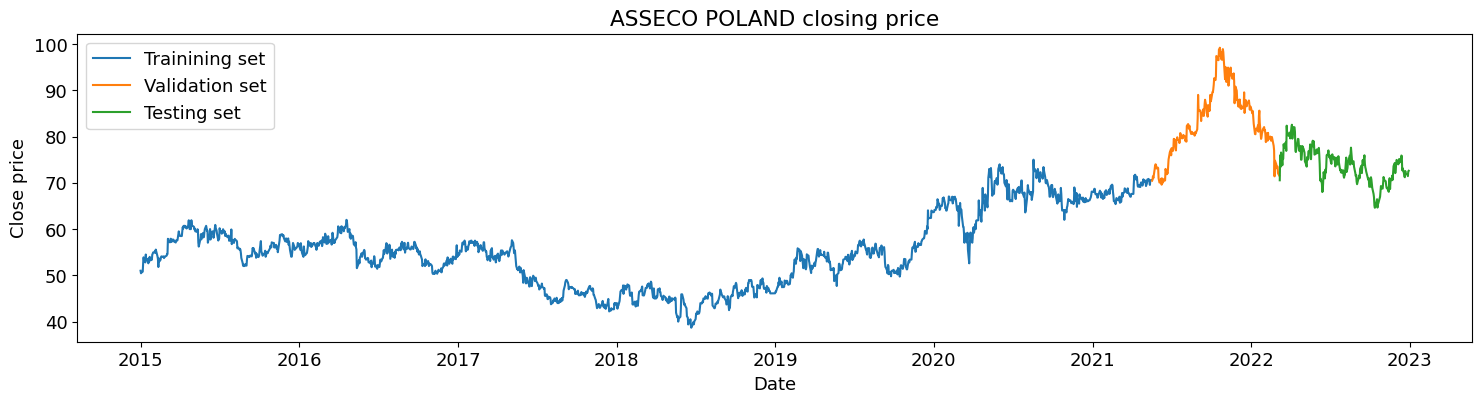

[*********************100%***********************]  1 of 1 completed
2014
1612
201
201


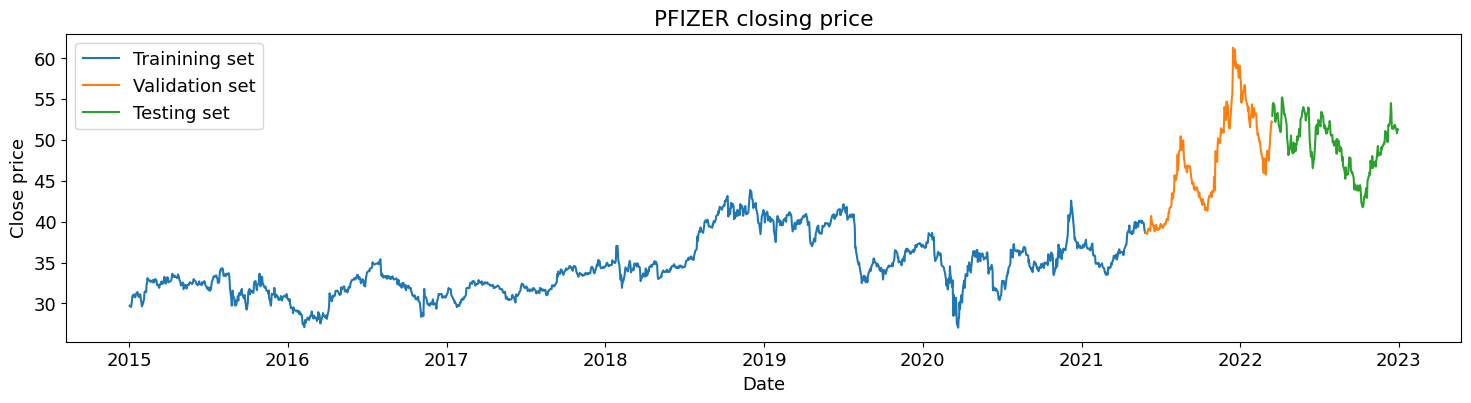

In [2]:
from my_library import *

# LSTM

## Stock 1

In [3]:
class MyHyperModelLSTM(keras_tuner.HyperModel):

    def build(self, hp):
        window = 30
        num_features = 1
        model = keras.Sequential()
        num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
        
        model.add(Input(shape=(window, num_features)))
        if num_layers == 1:
            model.add(LSTM(units=hp.Choice('units_0', values=[8, 16, 32, 64, 128, 256, 512]), 
                              return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_0', values=[0.0, 0.2])))
        else:
            for i in range(num_layers-1):
                model.add(LSTM(units=hp.Choice('units_' + str(i), values=[8, 16, 32, 64, 128, 256, 512]),
                                            return_sequences=True))
                model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.0, 0.2])))
        
            model.add(LSTM(units=hp.Choice('units_' + str(num_layers-1), values=[8, 16, 32, 64, 128, 256, 512]), 
                                  return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_' + str(num_layers-1), values=[0.0, 0.2])))
        model.add(Dense(hp.Choice('units_dense', values=[8, 16, 32, 64, 128, 256, 512]), 
                        activation=hp.Choice('activation_dense' , values=['relu', 'tanh'])))
        model.add(Dense(units=1, activation='linear'))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
        return model


    def fit(self, hp, model, train_data, **kwargs):
        window = 30
        features = 1
        X_train, y_train, X_val, y_val = prepare_data(hp, train_data, window, features)
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            **kwargs,
        )

tuner = BayesianOptimization(MyHyperModelLSTM(),
                     objective='val_loss',
                     max_trials=50,
                     executions_per_trial=2,
                     overwrite=True)

# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# Fit the tuner with early stopping
tuner.search(data, epochs=200, callbacks=[early_stop])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 50 Complete [00h 04m 04s]
val_loss: 0.5897689759731293

Best val_loss So Far: 0.583148866891861
Total elapsed time: 04h 13m 07s
INFO:tensorflow:Oracle triggered exit


Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_0 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_dense (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
Non

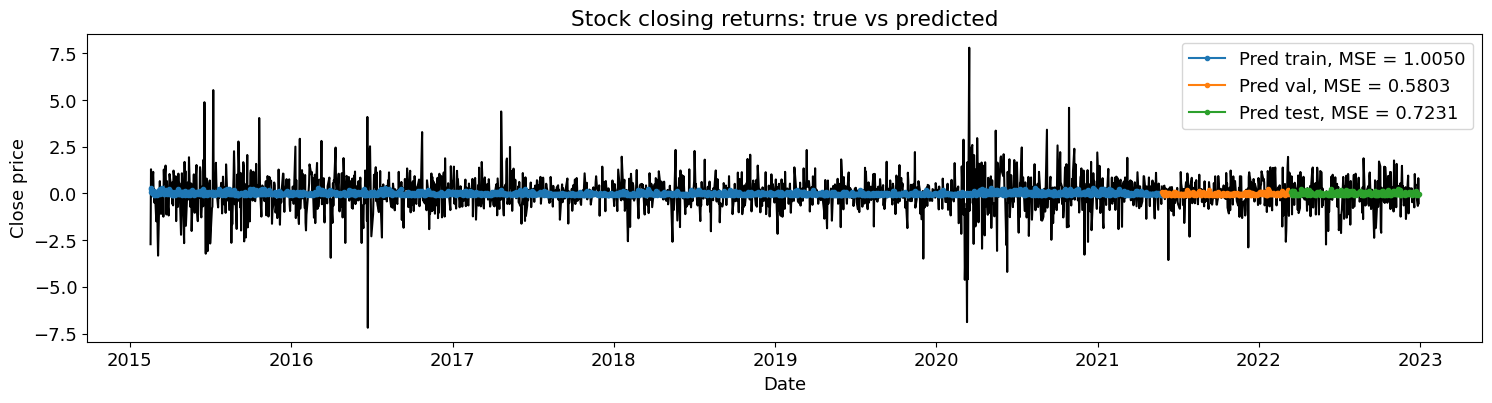

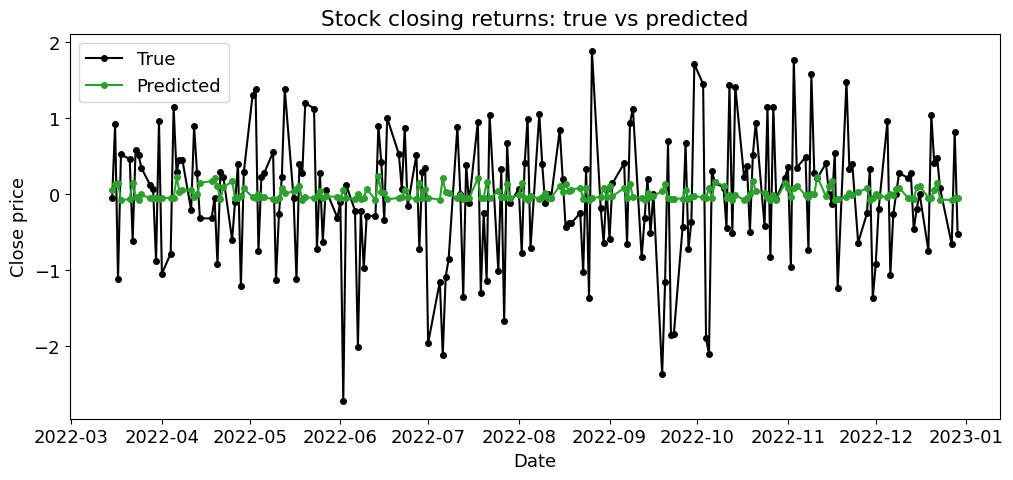

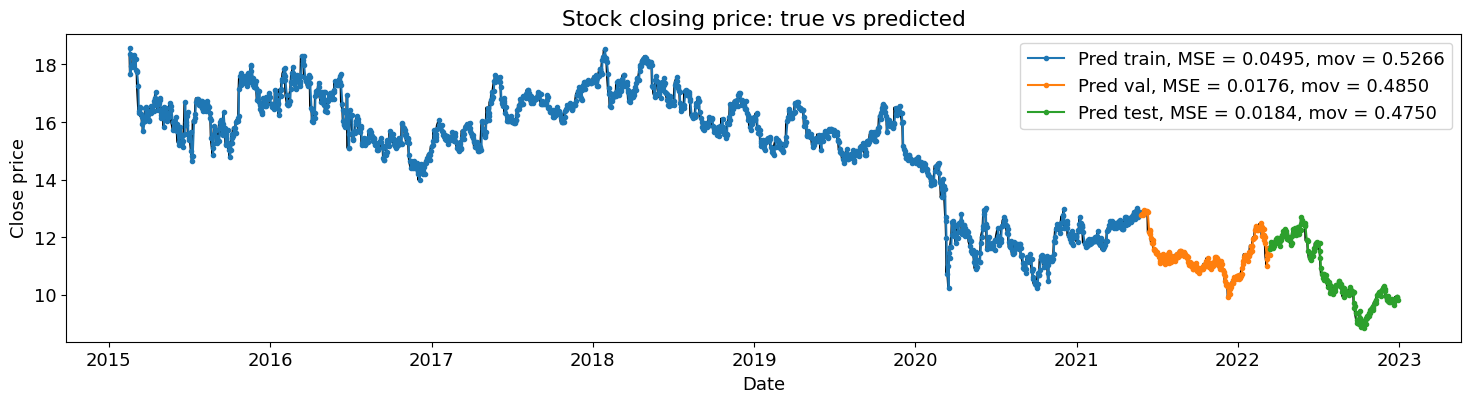

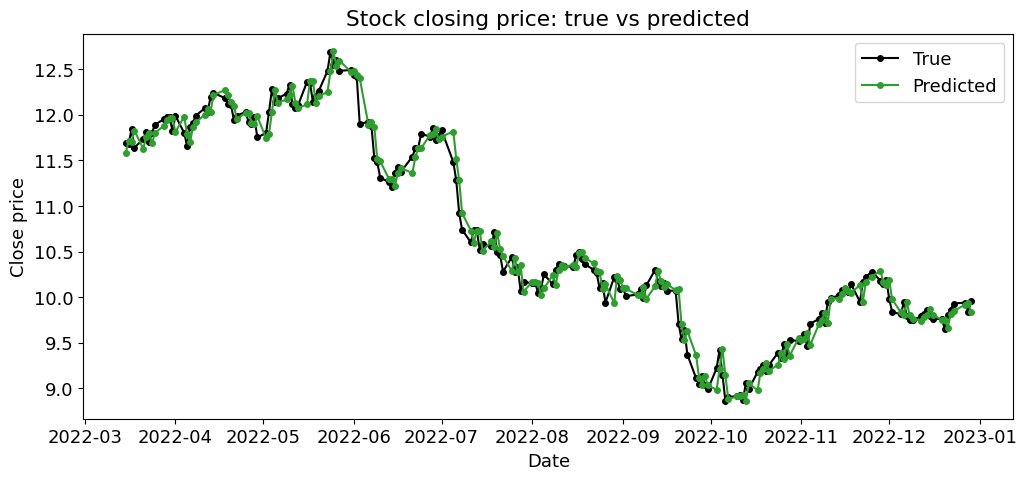

Results summary
Results in ./untitled_project
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 47 summary
Hyperparameters:
num_layers: 2
units_0: 256
dropout_0: 0.0
units_dense: 16
activation_dense: relu
units_1: 32
dropout_1: 0.2
units_2: 32
dropout_2: 0.2
Score: 0.583148866891861

Trial 00 summary
Hyperparameters:
num_layers: 1
units_0: 32
dropout_0: 0.0
units_dense: 8
activation_dense: relu
Score: 0.584407389163971

Trial 43 summary
Hyperparameters:
num_layers: 2
units_0: 512
dropout_0: 0.0
units_dense: 32
activation_dense: relu
units_1: 64
dropout_1: 0.2
units_2: 8
dropout_2: 0.2
Score: 0.588676780462265
None


In [4]:
best_model_check(data, tuner, best_model, window_size=30, features=1)
print(tuner.results_summary(num_trials=3))

## Stock 2

In [5]:
class MyHyperModelLSTM(keras_tuner.HyperModel):

    def build(self, hp):
        window = 30
        num_features = 1
        model = keras.Sequential()
        num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
        
        model.add(Input(shape=(window, num_features)))
        if num_layers == 1:
            model.add(LSTM(units=hp.Choice('units_0', values=[8, 16, 32, 64, 128, 256, 512]), 
                              return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_0', values=[0.0, 0.2])))
        else:
            for i in range(num_layers-1):
                model.add(LSTM(units=hp.Choice('units_' + str(i), values=[8, 16, 32, 64, 128, 256, 512]),
                                            return_sequences=True))
                model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.0, 0.2])))
        
            model.add(LSTM(units=hp.Choice('units_' + str(num_layers-1), values=[8, 16, 32, 64, 128, 256, 512]), 
                                  return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_' + str(num_layers-1), values=[0.0, 0.2])))
        model.add(Dense(hp.Choice('units_dense', values=[8, 16, 32, 64, 128, 256, 512]), 
                        activation=hp.Choice('activation_dense' , values=['relu', 'tanh'])))
        model.add(Dense(units=1, activation='linear'))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
        return model


    def fit(self, hp, model, train_data, **kwargs):
        window = 30
        features = 1
        X_train, y_train, X_val, y_val = prepare_data(hp, train_data, window, features)
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            **kwargs,
        )

tuner = BayesianOptimization(MyHyperModelLSTM(),
                     objective='val_loss',
                     max_trials=50,
                     executions_per_trial=2,
                     overwrite=True)

# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# Fit the tuner with early stopping
tuner.search(data2, epochs=200, callbacks=[early_stop])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 50 Complete [00h 09m 12s]
val_loss: 0.9209869503974915

Best val_loss So Far: 0.8925505876541138
Total elapsed time: 03h 53m 32s
INFO:tensorflow:Oracle triggered exit


Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_0 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_dense (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
Non

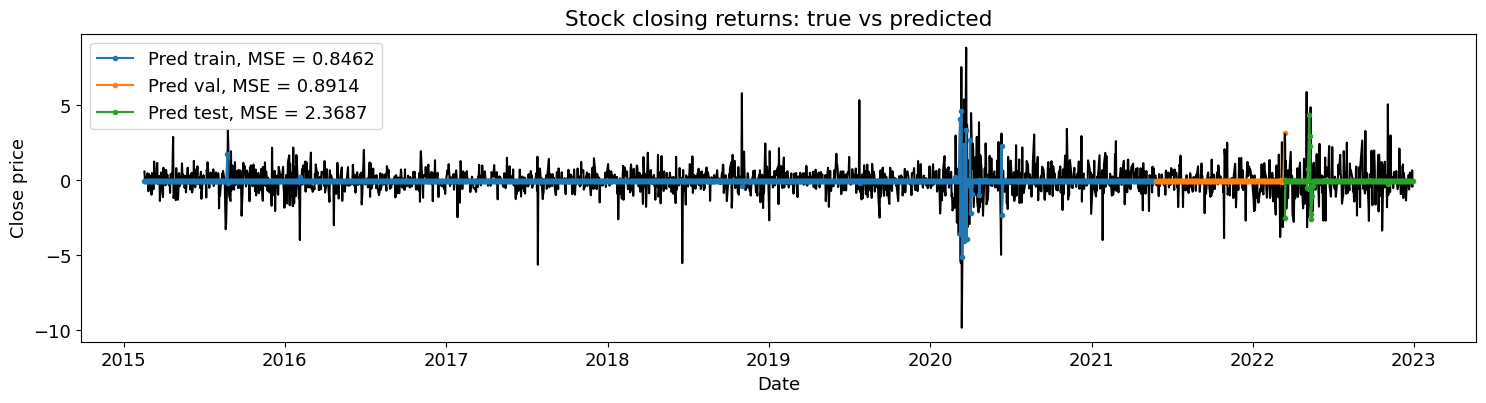

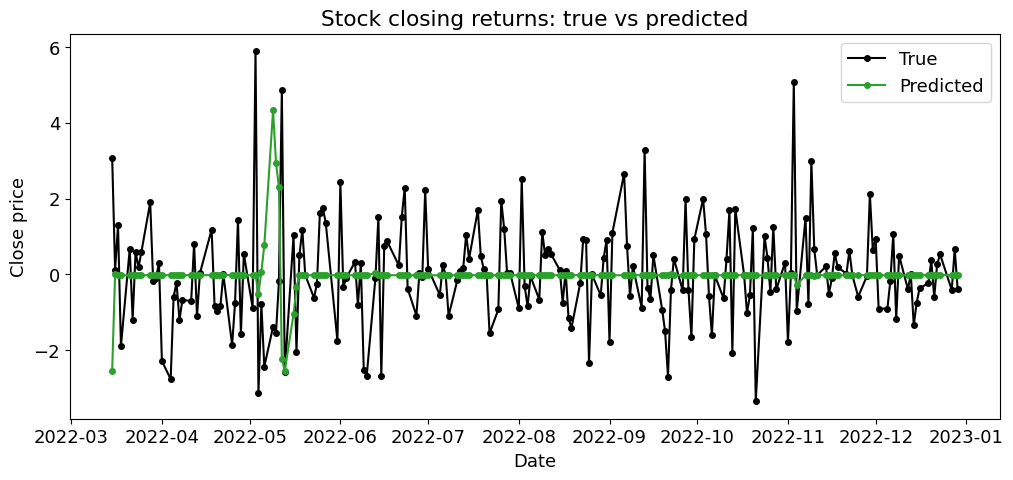

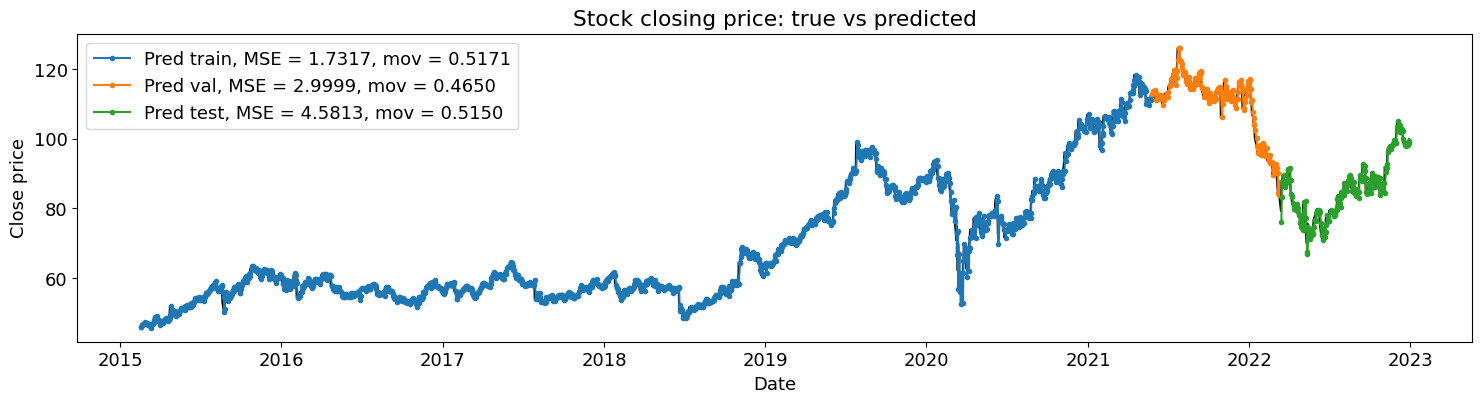

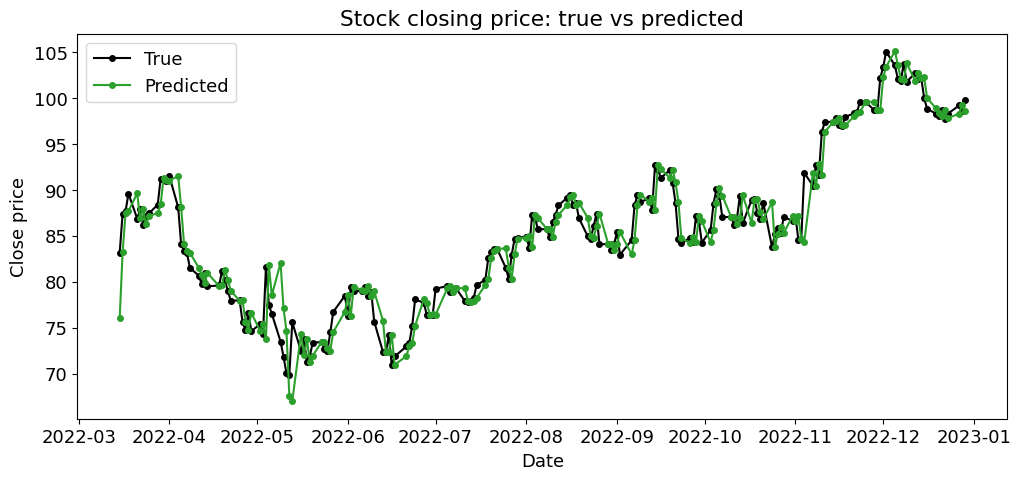

Results summary
Results in ./untitled_project
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 45 summary
Hyperparameters:
num_layers: 1
units_0: 8
dropout_0: 0.2
units_dense: 512
activation_dense: relu
units_1: 512
dropout_1: 0.0
units_2: 8
dropout_2: 0.2
Score: 0.8925505876541138

Trial 33 summary
Hyperparameters:
num_layers: 1
units_0: 128
dropout_0: 0.0
units_dense: 64
activation_dense: tanh
units_1: 64
dropout_1: 0.2
units_2: 64
dropout_2: 0.2
Score: 0.8928191363811493

Trial 41 summary
Hyperparameters:
num_layers: 1
units_0: 8
dropout_0: 0.2
units_dense: 32
activation_dense: relu
units_1: 256
dropout_1: 0.2
units_2: 16
dropout_2: 0.0
Score: 0.8944655358791351
None


In [6]:
best_model_check(data2, tuner, best_model, window_size=30, features=1)
print(tuner.results_summary(num_trials=3))

## Stock 3

In [ ]:
class MyHyperModelLSTM(keras_tuner.HyperModel):

    def build(self, hp):
        window = 30
        num_features = 1
        model = keras.Sequential()
        num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
        
        model.add(Input(shape=(window, num_features)))
        if num_layers == 1:
            model.add(LSTM(units=hp.Choice('units_0', values=[8, 16, 32, 64, 128, 256, 512]), 
                              return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_0', values=[0.0, 0.2])))
        else:
            for i in range(num_layers-1):
                model.add(LSTM(units=hp.Choice('units_' + str(i), values=[8, 16, 32, 64, 128, 256, 512]),
                                            return_sequences=True))
                model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.0, 0.2])))
        
            model.add(LSTM(units=hp.Choice('units_' + str(num_layers-1), values=[8, 16, 32, 64, 128, 256, 512]), 
                                  return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_' + str(num_layers-1), values=[0.0, 0.2])))
        model.add(Dense(hp.Choice('units_dense', values=[8, 16, 32, 64, 128, 256, 512]), 
                        activation=hp.Choice('activation_dense' , values=['relu', 'tanh'])))
        model.add(Dense(units=1, activation='linear'))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
        return model


    def fit(self, hp, model, train_data, **kwargs):
        window = 30
        features = 1
        X_train, y_train, X_val, y_val = prepare_data(hp, train_data, window, features)
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            **kwargs,
        )

tuner = BayesianOptimization(MyHyperModelLSTM(),
                     objective='val_loss',
                     max_trials=50,
                     executions_per_trial=2,
                     overwrite=True)

# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# Fit the tuner with early stopping
tuner.search(data3, epochs=200, callbacks=[early_stop])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 50 Complete [00h 00m 33s]
val_loss: 1.0756353735923767

Best val_loss So Far: 1.0631950497627258
Total elapsed time: 02h 09m 14s
INFO:tensorflow:Oracle triggered exit


2023-05-20 22:58:10.567750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-20 22:58:10.569643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-20 22:58:10.571283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_0 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_dense (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
Non

2023-05-20 22:58:10.931818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-20 22:58:10.934167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-20 22:58:10.935986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/7 [===>..........................] - ETA: 3s - loss: 2.5318 - mse: 2.5318

2023-05-20 22:58:11.177763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-20 22:58:11.179716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-20 22:58:11.181461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 5ms/step - loss: 1.3624 - mse: 1.3624

Test loss: 1.3624036312103271
Test MSE: 1.3624036312103271
 1/51 [..............................] - ETA: 18s

2023-05-20 22:58:11.635161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-20 22:58:11.637519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-20 22:58:11.639264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 4ms/step


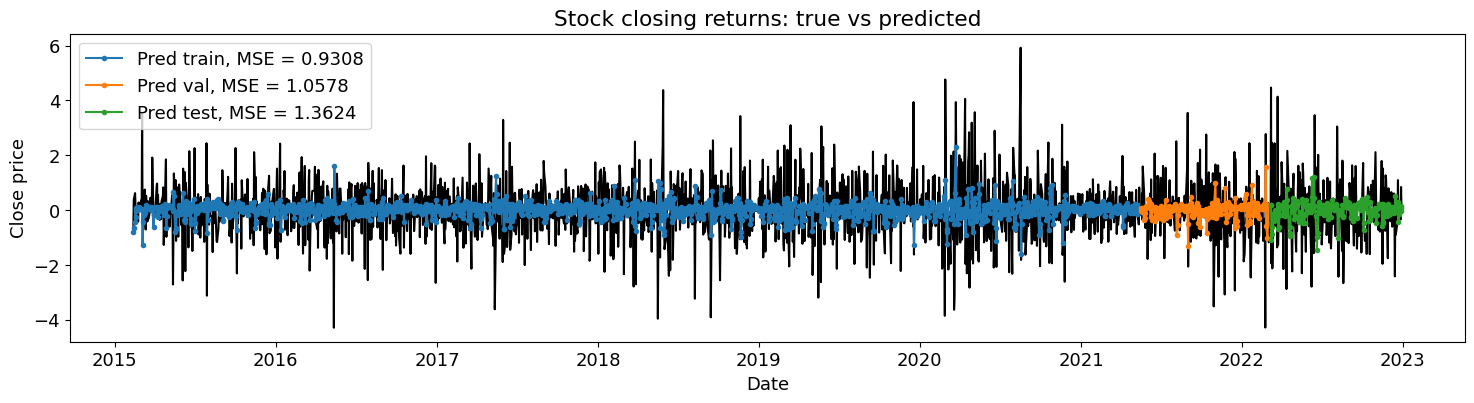

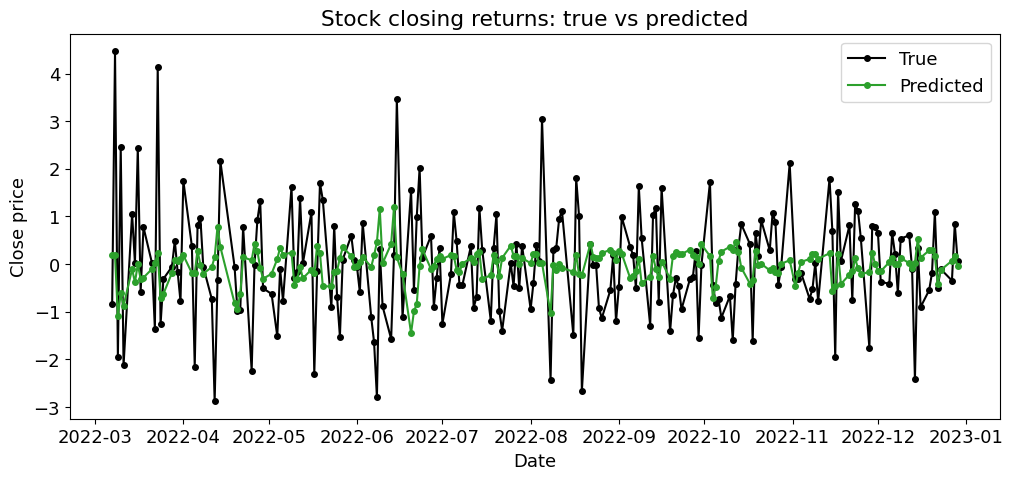

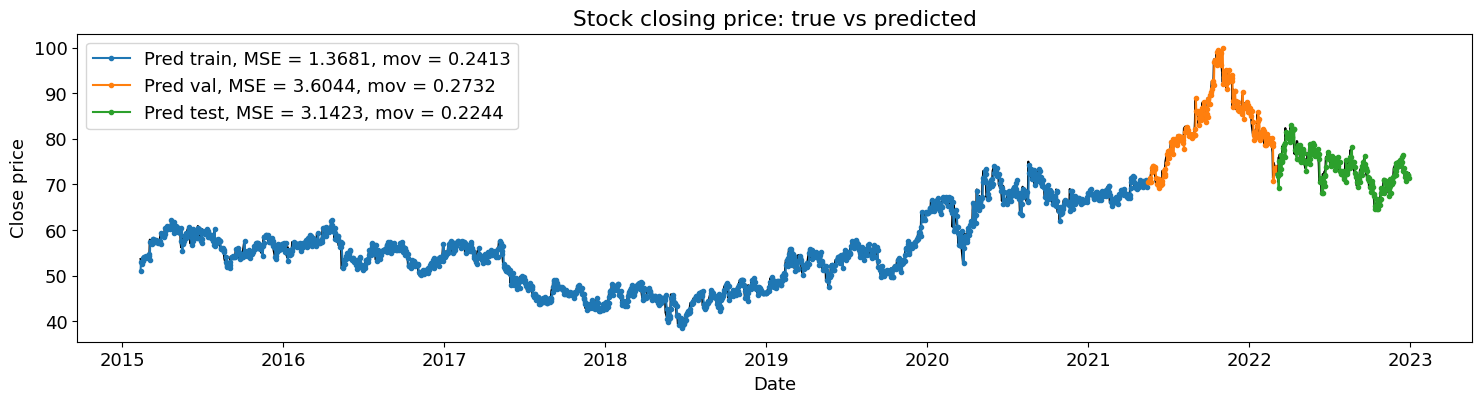

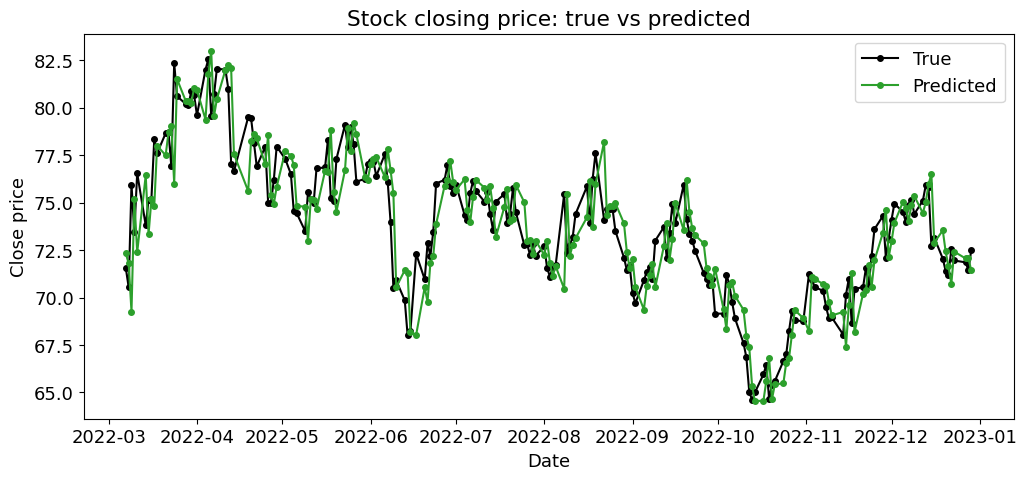

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 45 summary
Hyperparameters:
num_layers: 1
units_0: 8
dropout_0: 0.0
units_dense: 512
activation_dense: relu
units_1: 512
dropout_1: 0.0
units_2: 8
dropout_2: 0.0
Score: 1.0631950497627258
None


In [ ]:
best_model_check(data3, tuner, best_model, window_size=30, features=1)
print(tuner.results_summary(num_trials=1))

## Stock 4

In [ ]:
class MyHyperModelLSTM(keras_tuner.HyperModel):

    def build(self, hp):
        window = 30
        num_features = 1
        model = keras.Sequential()
        num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)
        
        model.add(Input(shape=(window, num_features)))
        if num_layers == 1:
            model.add(LSTM(units=hp.Choice('units_0', values=[8, 16, 32, 64, 128, 256, 512]), 
                              return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_0', values=[0.0, 0.2])))
        else:
            for i in range(num_layers-1):
                model.add(LSTM(units=hp.Choice('units_' + str(i), values=[8, 16, 32, 64, 128, 256, 512]),
                                            return_sequences=True))
                model.add(Dropout(hp.Choice('dropout_' + str(i), values=[0.0, 0.2])))
        
            model.add(LSTM(units=hp.Choice('units_' + str(num_layers-1), values=[8, 16, 32, 64, 128, 256, 512]), 
                                  return_sequences=False))
            model.add(Dropout(hp.Choice('dropout_' + str(num_layers-1), values=[0.0, 0.2])))
        model.add(Dense(hp.Choice('units_dense', values=[8, 16, 32, 64, 128, 256, 512]), 
                        activation=hp.Choice('activation_dense' , values=['relu', 'tanh'])))
        model.add(Dense(units=1, activation='linear'))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
        return model


    def fit(self, hp, model, train_data, **kwargs):
        window = 30
        features = 1
        X_train, y_train, X_val, y_val = prepare_data(hp, train_data, window, features)
        return model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            **kwargs,
        )

tuner = BayesianOptimization(MyHyperModelLSTM(),
                     objective='val_loss',
                     max_trials=50,
                     executions_per_trial=2,
                     overwrite=True)

# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# Fit the tuner with early stopping
tuner.search(data4, epochs=200, callbacks=[early_stop])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 50 Complete [00h 00m 56s]
val_loss: 2.003908693790436

Best val_loss So Far: 2.003908693790436
Total elapsed time: 02h 56m 57s
INFO:tensorflow:Oracle triggered exit


2023-05-21 01:55:11.080297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 01:55:11.082124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 01:55:11.083702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Search space summary
Default search space size: 9
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_0 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_dense (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_1 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
units_2 (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128, 256, 512], 'ordered': True}
dropout_2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2], 'ordered': True}
Non

2023-05-21 01:55:11.428412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 01:55:11.430380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 01:55:11.432063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/7 [===>..........................] - ETA: 3s - loss: 1.7440 - mse: 1.7440

2023-05-21 01:55:11.672485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 01:55:11.674215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 01:55:11.675838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 7ms/step - loss: 1.4346 - mse: 1.4346

Test loss: 1.434561014175415
Test MSE: 1.434561014175415
 9/50 [====>.........................] - ETA: 0s 

2023-05-21 01:55:12.135873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 01:55:12.138088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 01:55:12.139662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 6ms/step


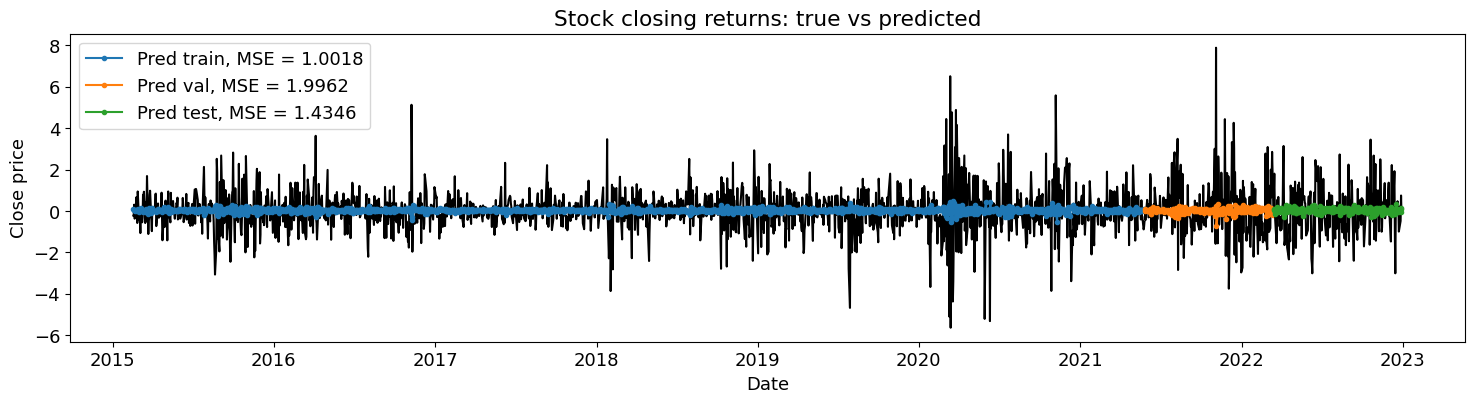

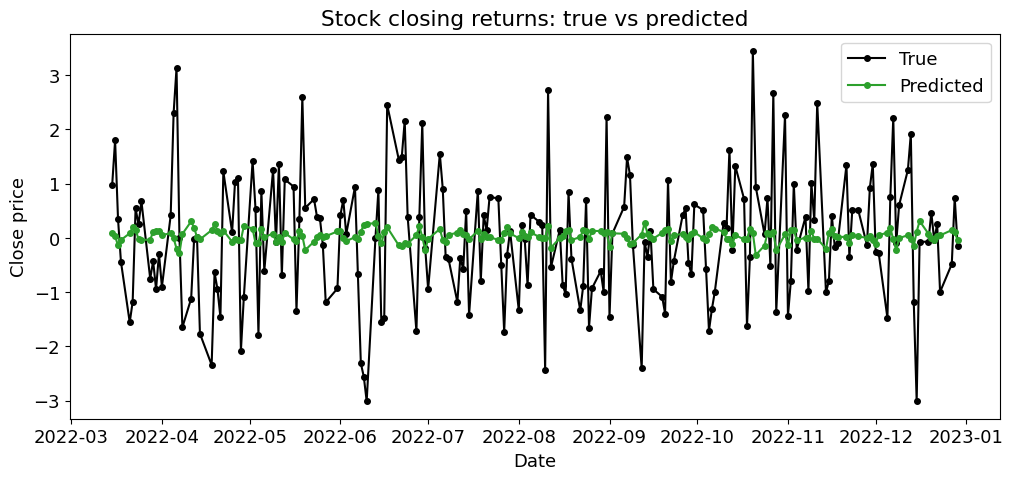

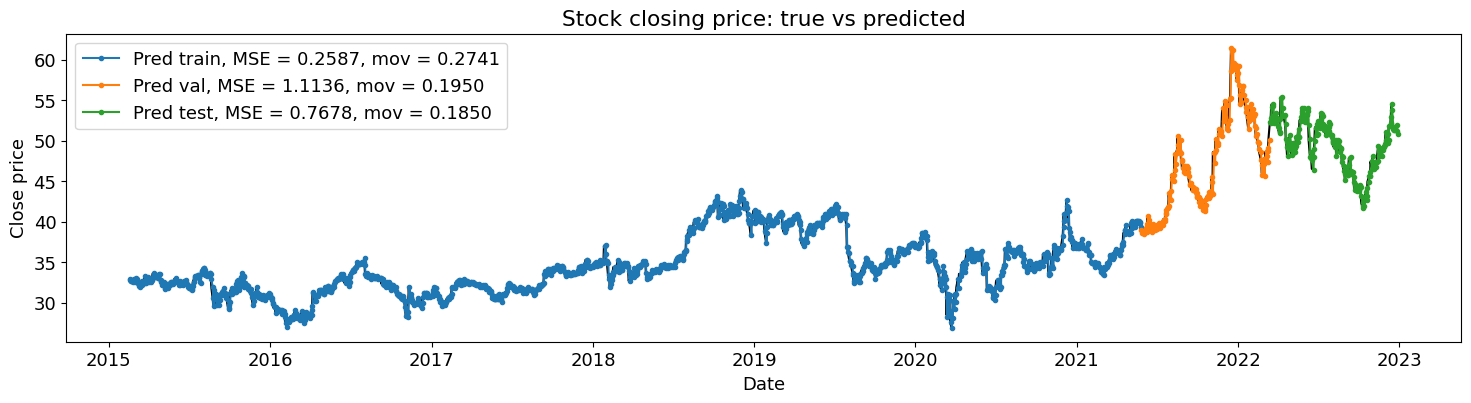

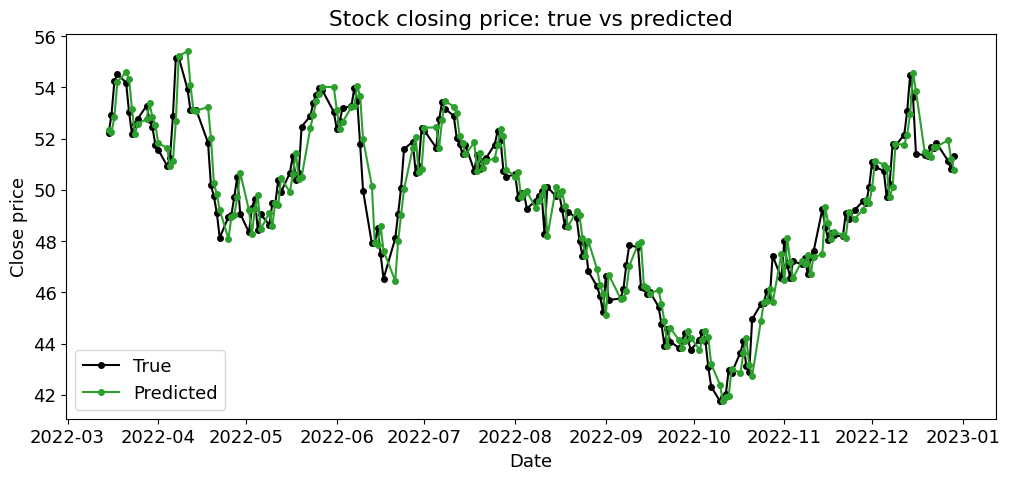

Results summary
Results in ./untitled_project
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 49 summary
Hyperparameters:
num_layers: 1
units_0: 64
dropout_0: 0.0
units_dense: 512
activation_dense: tanh
units_1: 64
dropout_1: 0.0
units_2: 32
dropout_2: 0.0
Score: 2.003908693790436

Trial 28 summary
Hyperparameters:
num_layers: 1
units_0: 64
dropout_0: 0.0
units_dense: 256
activation_dense: tanh
units_1: 32
dropout_1: 0.0
units_2: 32
dropout_2: 0.0
Score: 2.0103999972343445

Trial 30 summary
Hyperparameters:
num_layers: 1
units_0: 64
dropout_0: 0.0
units_dense: 256
activation_dense: tanh
units_1: 16
dropout_1: 0.0
units_2: 32
dropout_2: 0.0
Score: 2.015998661518097
None


In [ ]:
best_model_check(data4, tuner, best_model, window_size=30, features=1)
print(tuner.results_summary(num_trials=3))